# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [101]:
# Import essential libraries for data manipulation and analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [15]:
# Importing the file porter_data_1.csv
df = pd.read_csv('porter_data_1.csv')

df.head()

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [81]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [82]:
# Find categorical columns
categorical_columns = df.select_dtypes(include='object').columns

# Convert to category dtype
for col in categorical_columns:
    df[col] = df[col].astype('category')


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [24]:
# Calculate time taken in minutes
df['delivery_time_min'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [84]:
# Extract the hour and day of week from the 'created_at' timestamp
# Extract hour
df['created_hour'] = df['created_at'].dt.hour

# Extract day of week (Monday=0, Sunday=6)
df['created_day_of_week'] = df['created_at'].dt.dayofweek

# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['created_day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


In [85]:
# Drop unnecessary columns
df = df.drop(columns=['created_at', 'actual_delivery_time', 'created_day_of_week'])

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [86]:
# Define target variable (y) and features (X)
y = df['delivery_time_min']

X = df[['distance', 'total_items', 'subtotal', 'total_onshift_dashers',
        'total_busy_dashers', 'total_outstanding_orders', 'order_hour', 'order_dayofweek']]


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [87]:
# Split data into training and testing sets

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Display shape of resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (140621, 8)
X_test shape: (35156, 8)
y_train shape: (140621,)
y_test shape: (35156,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [30]:
# Define numerical and categorical columns for easy EDA and data manipulation

# Numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical columns
categorical_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()

# Display the lists
print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'delivery_time_min']
Categorical columns: ['market_id', 'store_primary_category', 'order_protocol']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

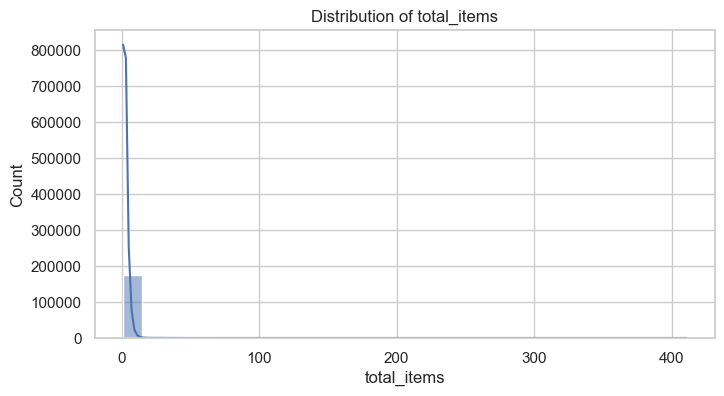

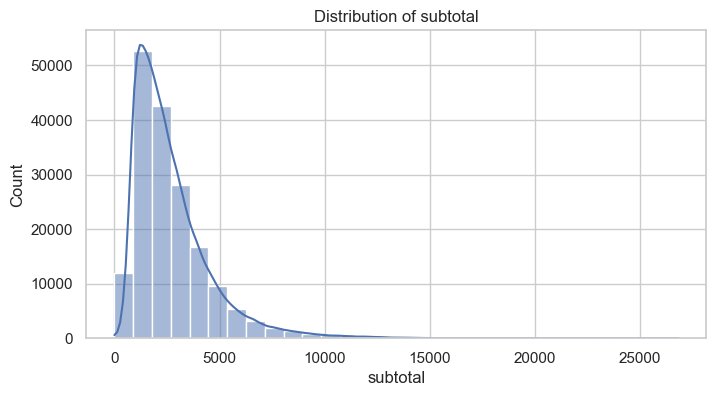

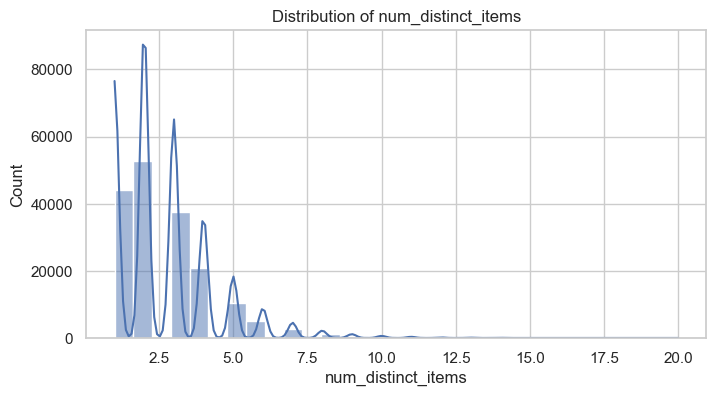

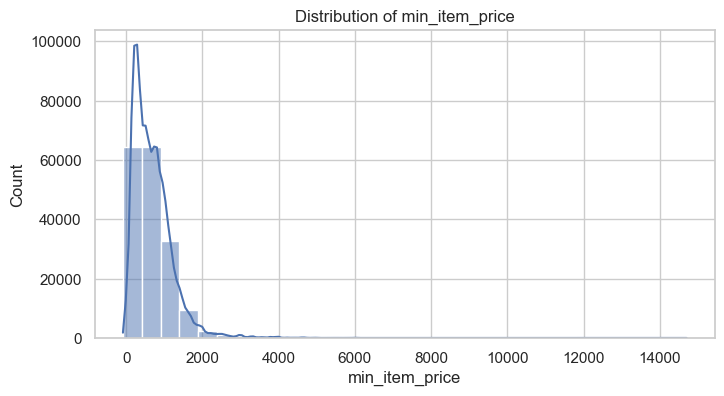

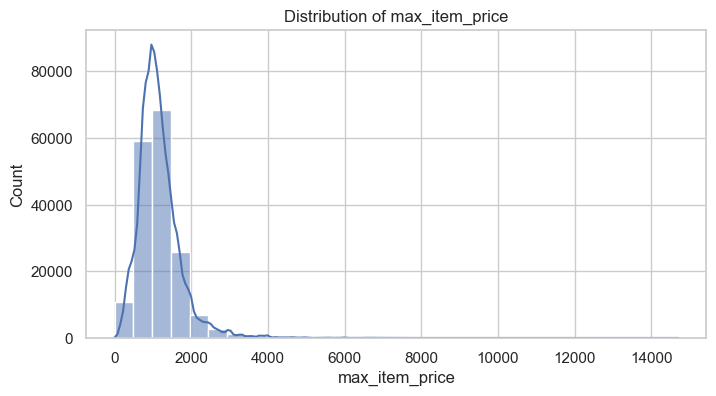

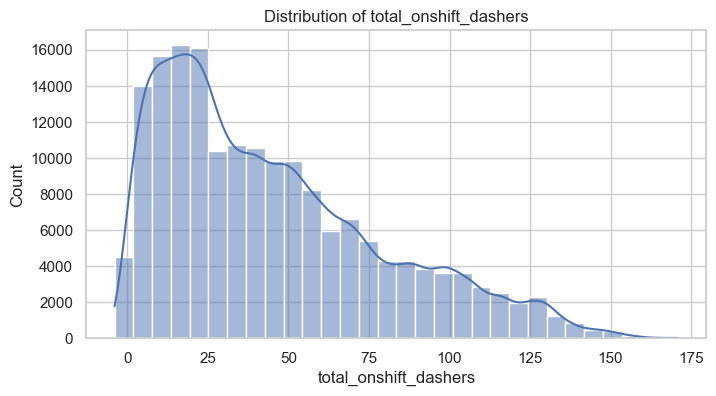

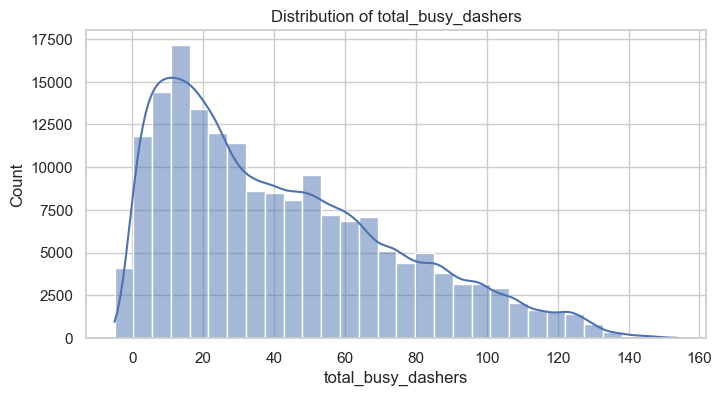

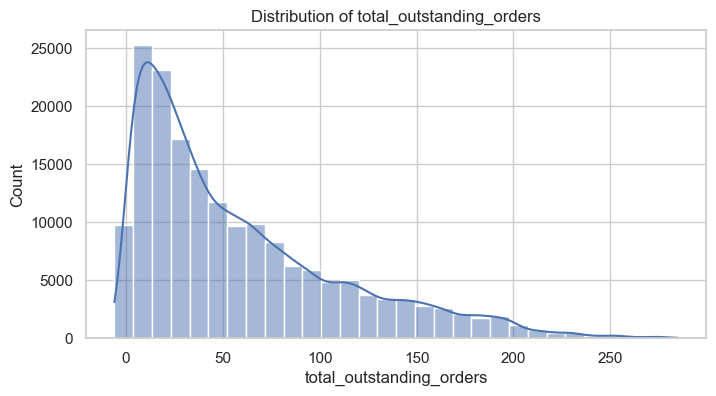

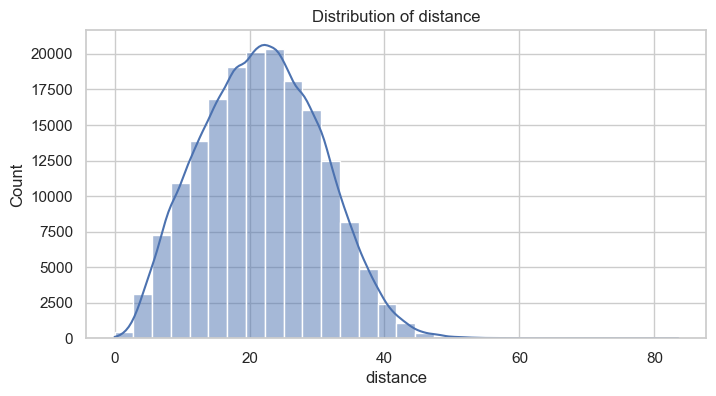

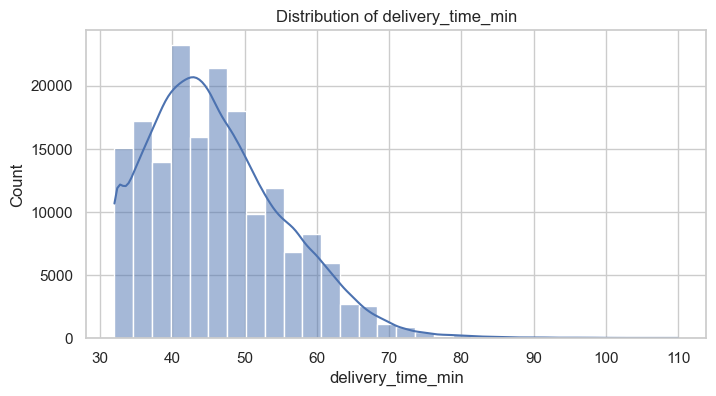

In [31]:
# Plot distributions for all numerical columns
# Set style
sns.set(style='whitegrid')

# Loop over numerical columns and plot
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()


##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

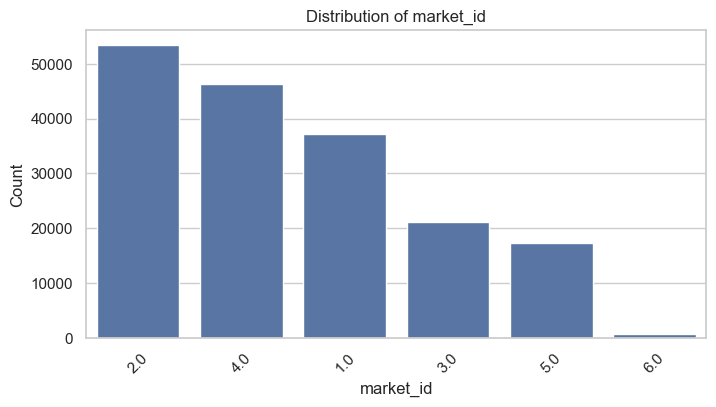

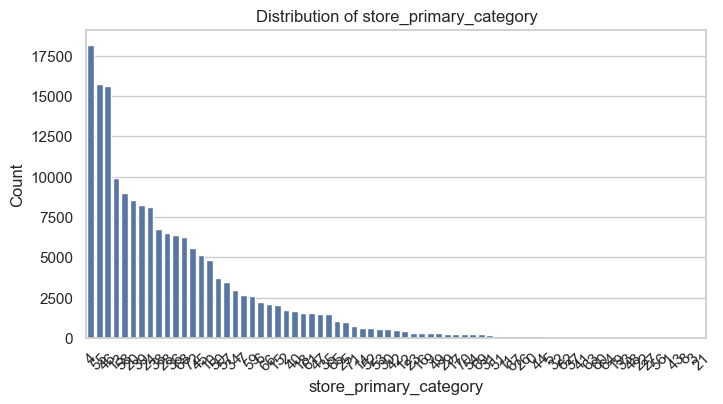

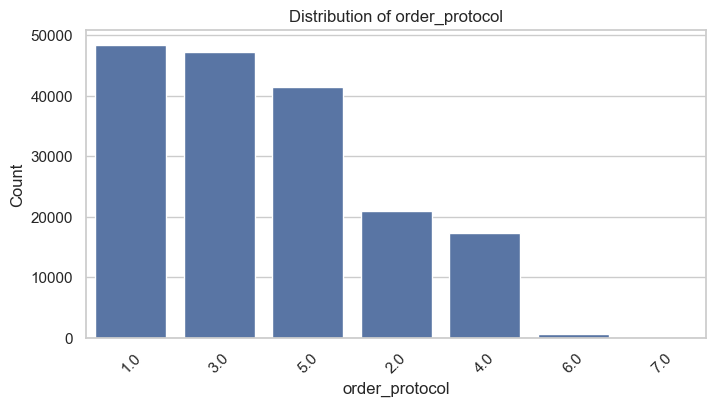

In [32]:
# Distribution of categorical columns
# Set style
sns.set(style='whitegrid')

# Loop over categorical columns and plot countplots
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate if category names are long
    plt.show()


##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

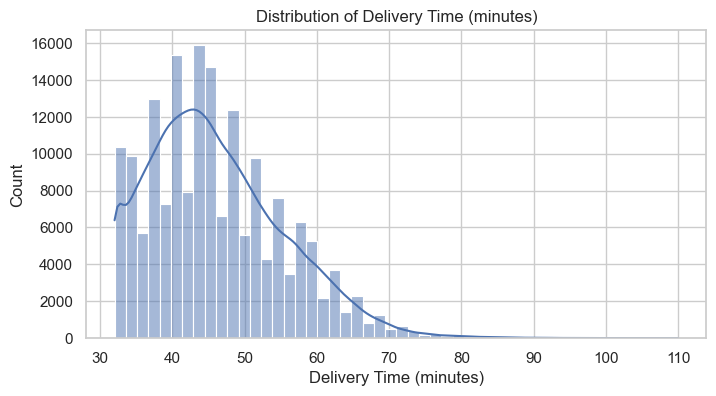

In [33]:
# Distribution of time_taken
plt.figure(figsize=(8, 4))
sns.histplot(df['delivery_time_min'], kde=True, bins=50)
plt.title('Distribution of Delivery Time (minutes)')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Count')
plt.show()


#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

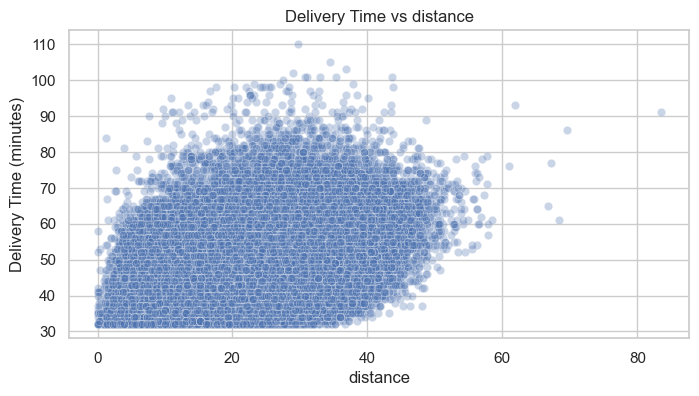

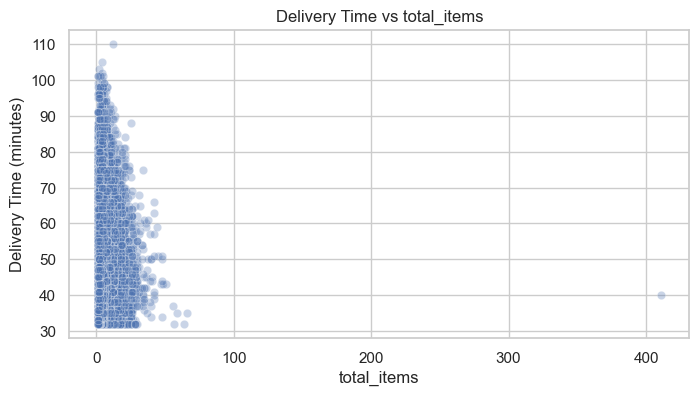

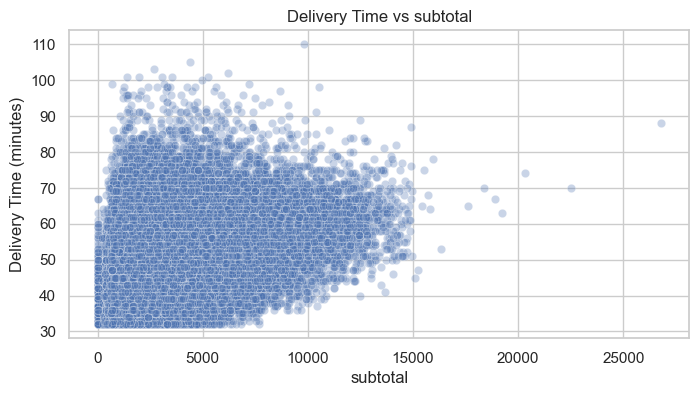

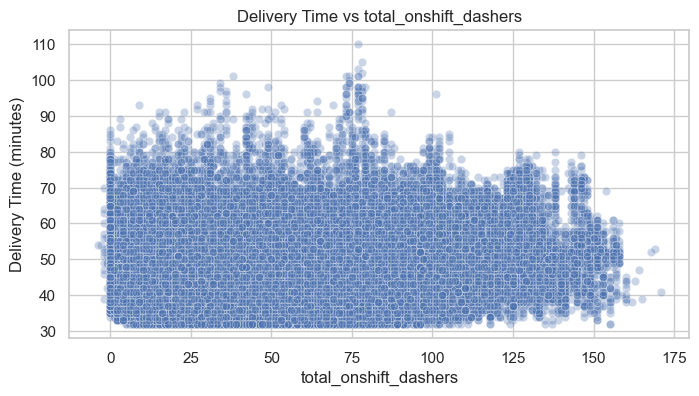

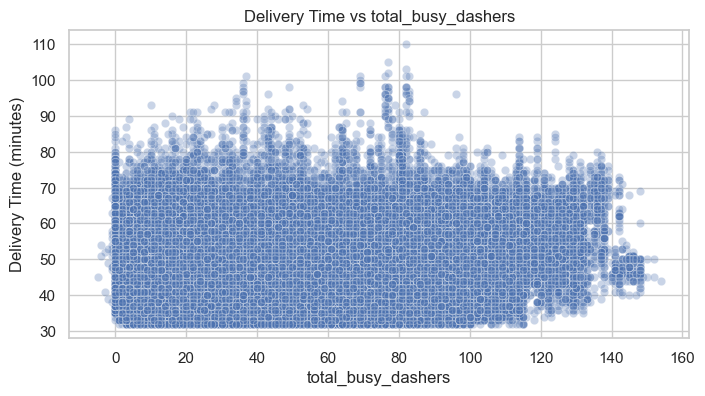

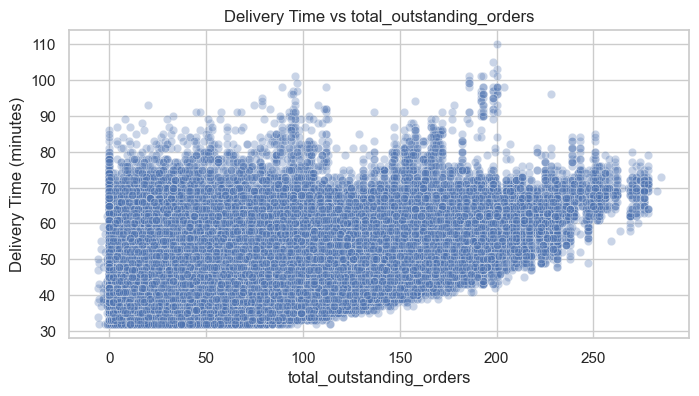

In [34]:
# Scatter plot to visualise the relationship between time_taken and other features


features_to_plot = ['distance', 'total_items', 'subtotal', 'total_onshift_dashers', 
                    'total_busy_dashers', 'total_outstanding_orders']

# Loop over selected features
for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.scatterplot(data=df, x=feature, y='delivery_time_min', alpha=0.3)
    plt.title(f'Delivery Time vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Delivery Time (minutes)')
    plt.show()

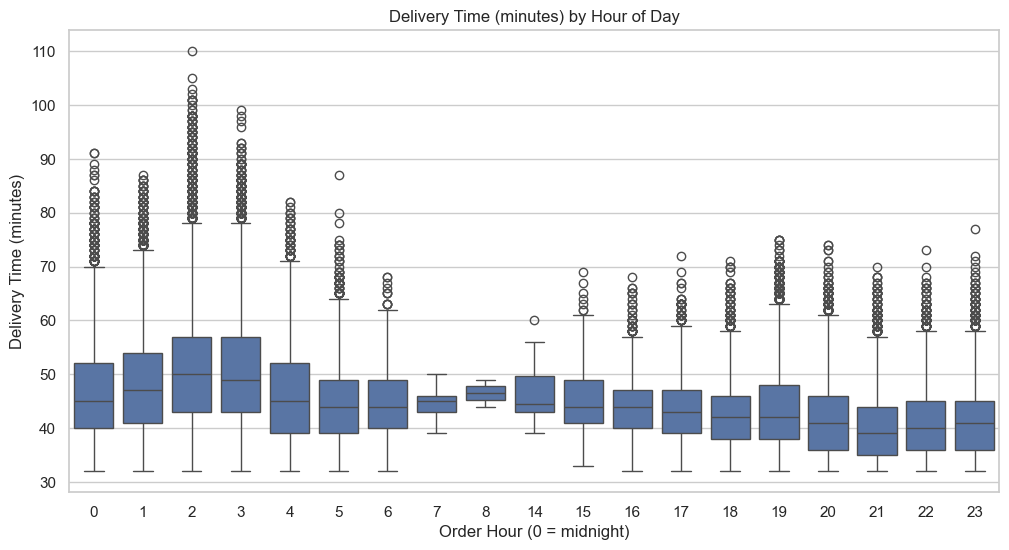

In [35]:
# Show the distribution of time_taken for different hours
plt.figure(figsize=(12, 6))
sns.boxplot(x='order_hour', y='delivery_time_min', data=df)
plt.title('Delivery Time (minutes) by Hour of Day')
plt.xlabel('Order Hour (0 = midnight)')
plt.ylabel('Delivery Time (minutes)')
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

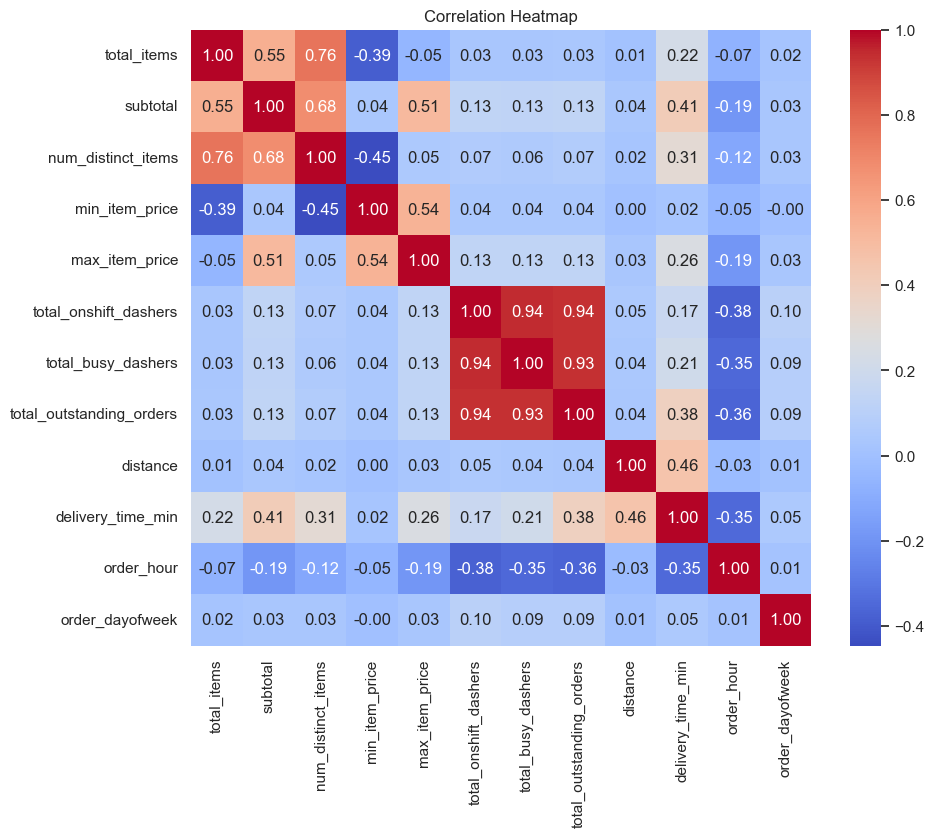

In [36]:
# Plot the heatmap of the correlation matrix


plt.figure(figsize=(10, 8))
corr_matrix = df.corr(numeric_only=True)

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [88]:
# Drop 3-5 weakly correlated columns from training dataset
# Drop weakly correlated columns
cols_to_drop = [
    'min_item_price', 
    'total_onshift_dashers', 
    'total_busy_dashers', 
    'order_dayofweek'
]

df = df.drop(columns=cols_to_drop)

# Define target variable
y = df['delivery_time_min']

# Define input features (after dropping weak columns)
X = df[['distance', 'total_items', 'subtotal', 'num_distinct_items',
        'total_outstanding_orders', 'order_hour']]


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

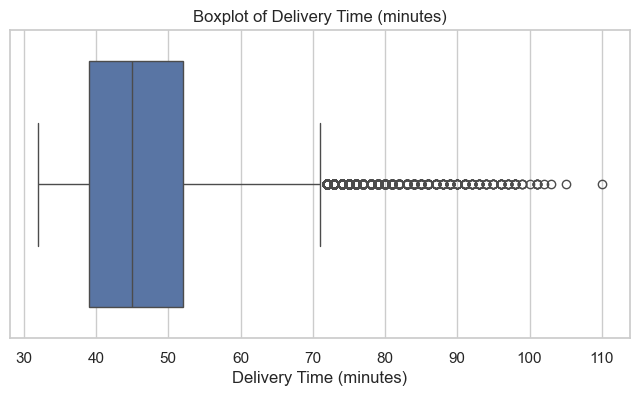

In [89]:
# Boxplot for time_taken
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['delivery_time_min'])
plt.title('Boxplot of Delivery Time (minutes)')
plt.xlabel('Delivery Time (minutes)')
plt.show()


##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

Original size: 175777, After removing outliers: 174028


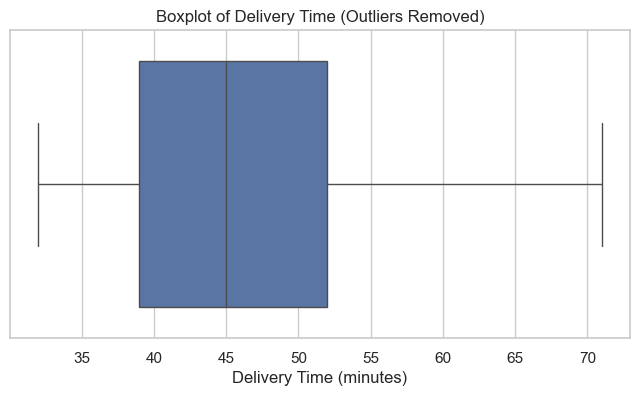

In [90]:
# Handle outliers

Q1 = df['delivery_time_min'].quantile(0.25)
Q3 = df['delivery_time_min'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter dataset
df_no_outliers = df[(df['delivery_time_min'] >= lower_bound) & (df['delivery_time_min'] <= upper_bound)]

print(f"Original size: {df.shape[0]}, After removing outliers: {df_no_outliers.shape[0]}")

# Boxplot after removing
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_no_outliers['delivery_time_min'])
plt.title('Boxplot of Delivery Time (Outliers Removed)')
plt.xlabel('Delivery Time (minutes)')
plt.show()

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [56]:
# Define numerical and categorical columns for easy EDA and data manipulation
numerical_cols = [
    'total_items',
    'subtotal',
    'num_distinct_items',
    'min_item_price',
    'max_item_price',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'distance',
    'delivery_time_min'
]

categorical_cols = [
    'order_hour',
    'order_dayofweek'
]

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)


Numerical columns: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'delivery_time_min']
Categorical columns: ['order_hour', 'order_dayofweek']


#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

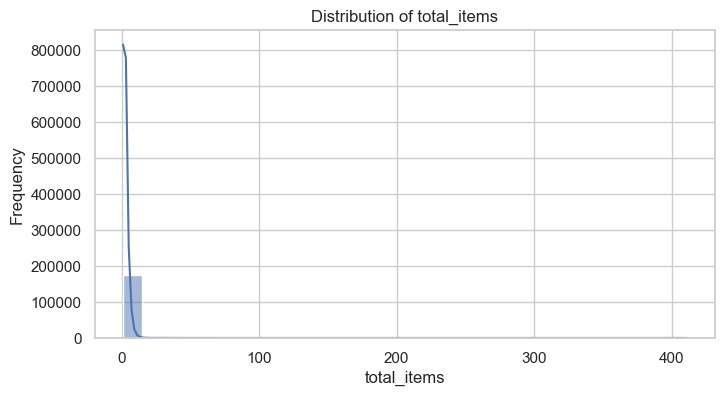

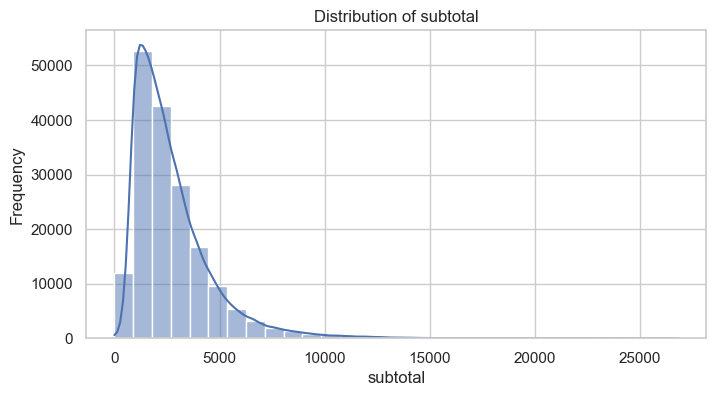

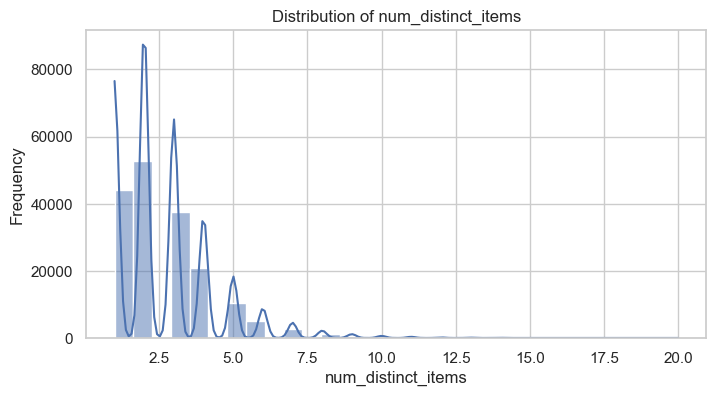

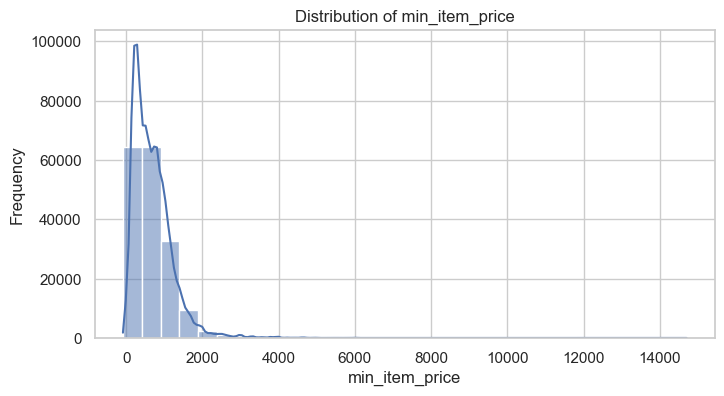

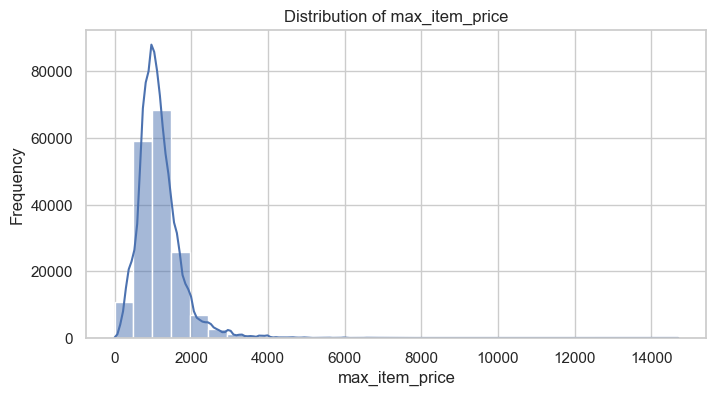

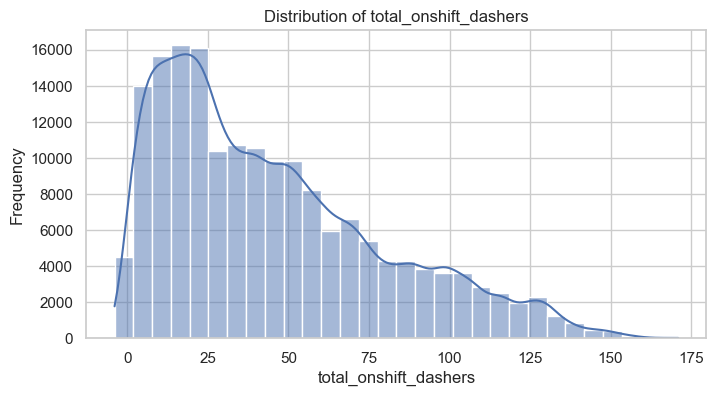

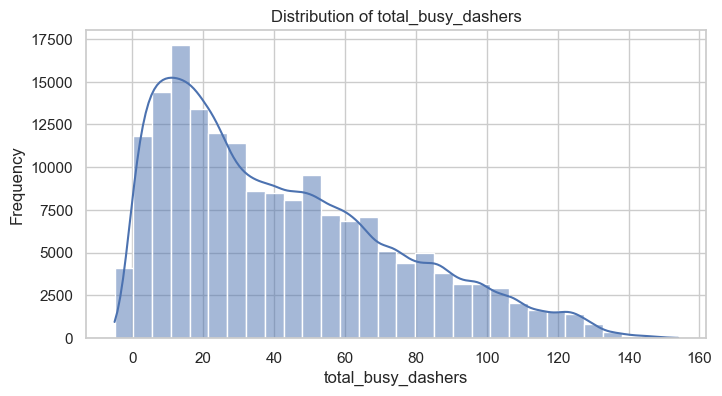

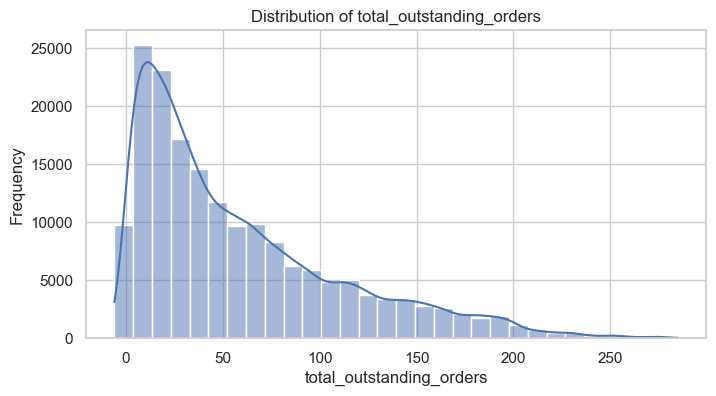

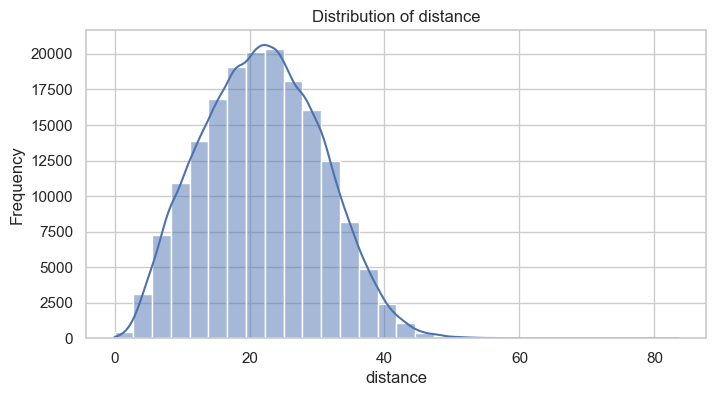

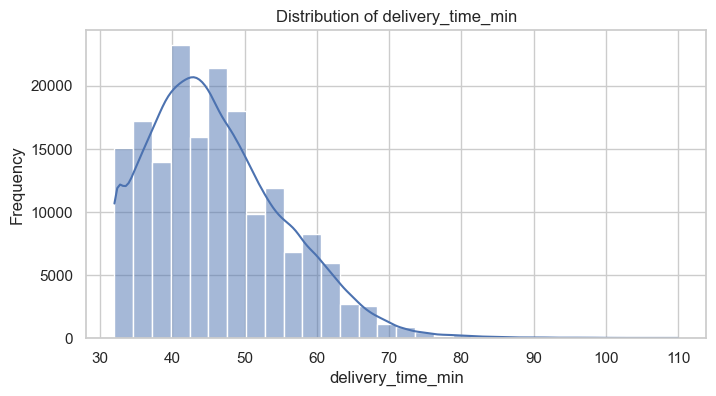

In [59]:
# Plot distributions for all numerical columns
# Set plot style
sns.set(style="whitegrid")

# Plot distribution for each numerical column
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


##### **4.1.2**
Check the distribution of categorical features

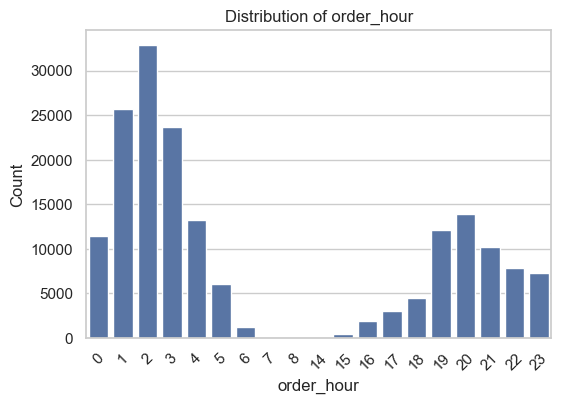

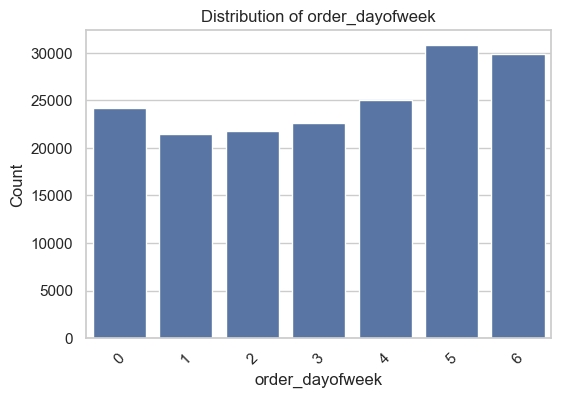

In [60]:
# Distribution of categorical columns
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)   # Rotate x-axis labels if needed
    plt.show()


##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

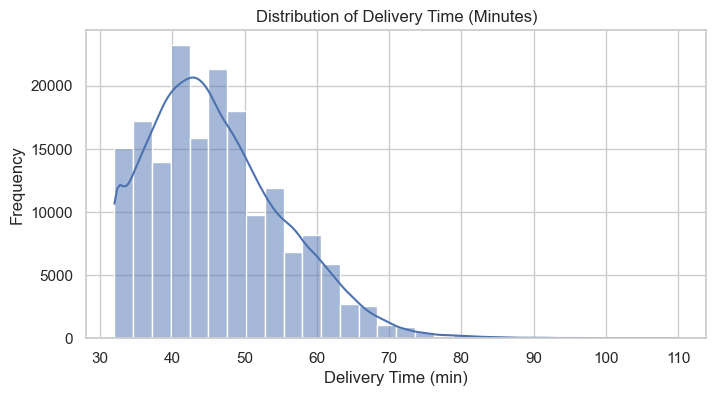

In [61]:
# Distribution of time_taken
plt.figure(figsize=(8, 4))
sns.histplot(df['delivery_time_min'], kde=True, bins=30)
plt.title('Distribution of Delivery Time (Minutes)')
plt.xlabel('Delivery Time (min)')
plt.ylabel('Frequency')
plt.show()


#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

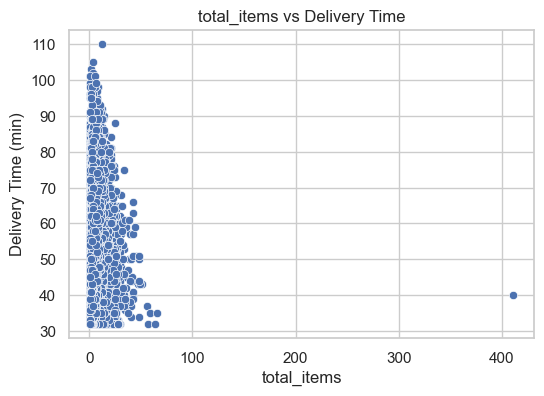

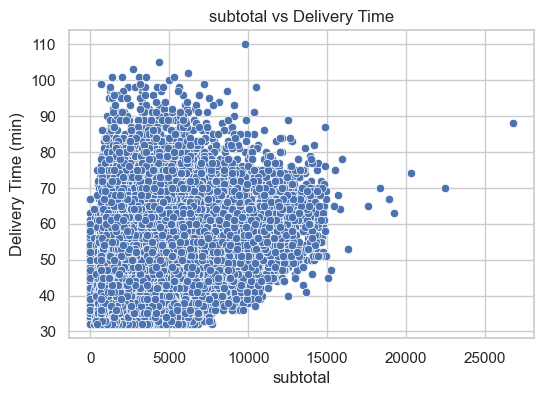

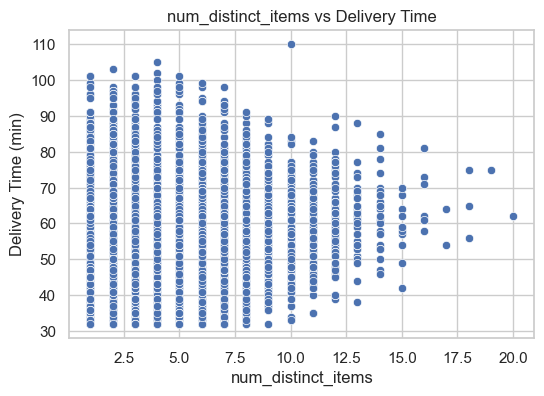

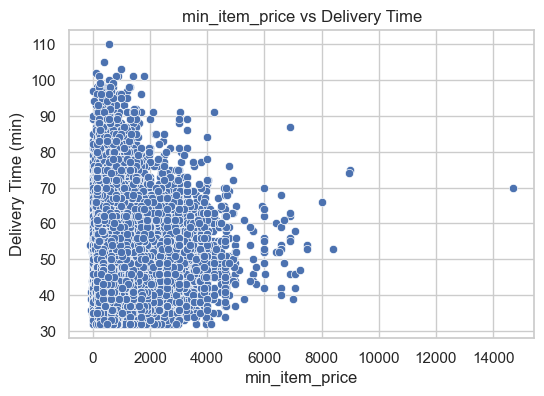

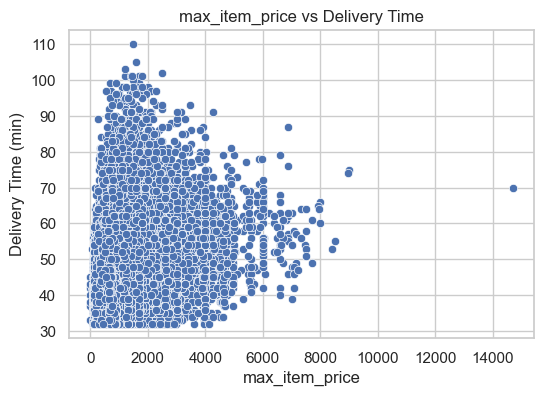

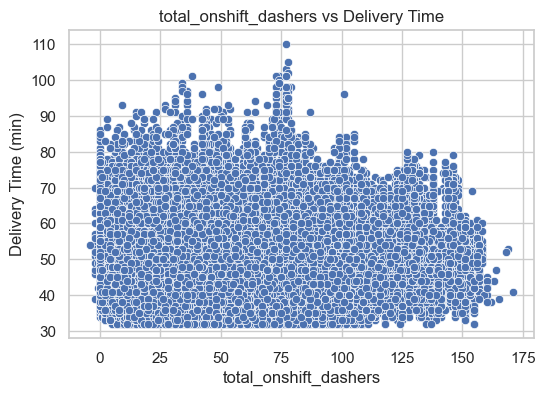

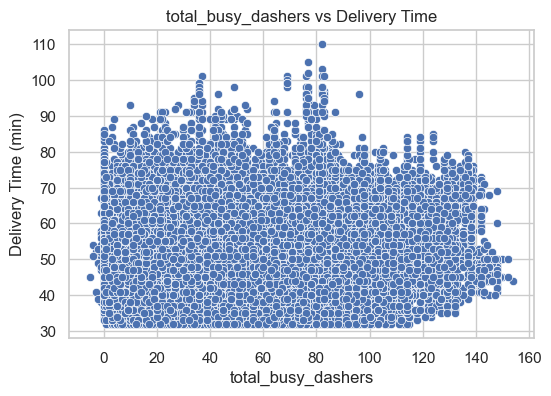

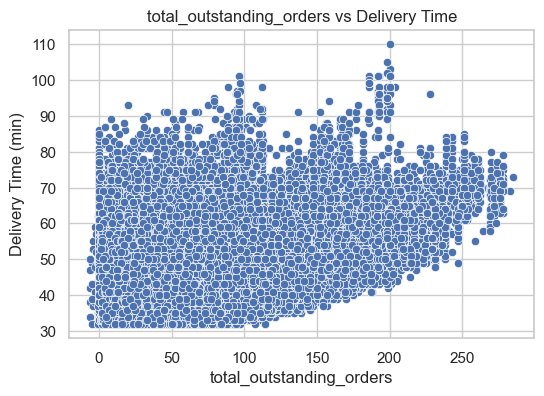

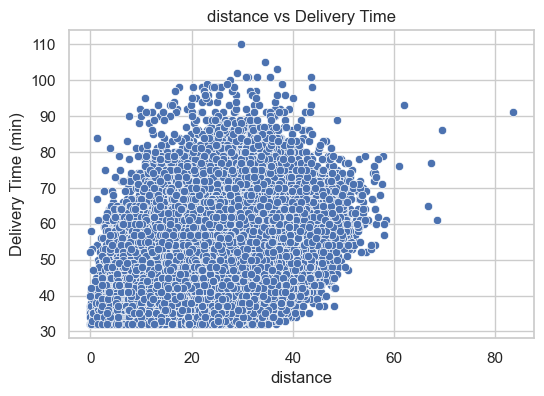

In [62]:
# Scatter plot to visualise the relationship between time_taken and other features

# Choose key numerical features to plot against delivery_time_min
for col in numerical_cols:
    if col != 'delivery_time_min':  # Don't plot target vs target
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=col, y='delivery_time_min', data=df)
        plt.title(f'{col} vs Delivery Time')
        plt.xlabel(col)
        plt.ylabel('Delivery Time (min)')
        plt.show()

#### **4.3** Drop the columns with weak correlations with the target variable

In [63]:
# Drop the weakly correlated columns from training dataset
cols_to_drop = [
    'min_item_price',
    'max_item_price',
    'total_items',
    'total_onshift_dashers',
    'total_busy_dashers'
]
df_model = df.drop(columns=cols_to_drop)

print(df_model.columns)

Index(['market_id', 'created_at', 'actual_delivery_time',
       'store_primary_category', 'order_protocol', 'subtotal',
       'num_distinct_items', 'total_outstanding_orders', 'distance',
       'delivery_time_min', 'order_hour', 'order_dayofweek'],
      dtype='object')


## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [98]:
# Import libraries

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE


#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [91]:
# Apply scaling to the numerical columns

# List of numerical columns
numerical_columns = [
    'subtotal',
    'num_distinct_items',
    'distance',
    'total_outstanding_orders',
    'order_hour'
]

# Initialize scaler
scaler = StandardScaler()

# Fit-transform numerical columns
df_scaled = df_model.copy()
df_scaled[numerical_columns] = scaler.fit_transform(df_scaled[numerical_columns])

# Check scaled values
df_scaled[numerical_columns].head()



subtotal  num_distinct_items  distance  total_outstanding_orders  \
0  0.406819            0.815009  1.439863                 -0.706040   
1 -0.435925           -1.030377  0.658031                 -1.066360   
2  1.134171            0.199880 -1.175387                 -0.762933   
3 -0.641006           -1.030377  1.138103                 -0.952575   
4  0.504711           -0.415249 -1.559444                 -0.971539   

   order_hour  
0    1.558937  
1    1.443687  
2   -0.976565  
3   -0.630814  
4   -0.746065

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [93]:
# Create/Initialise the model
lr_model = LinearRegression()

In [94]:
# Train the model using the training data
lr_model.fit(X_train, y_train)


LinearRegression()

In [95]:
# Make predictions
y_pred = lr_model.predict(X_test)

In [96]:
# Find results for evaluation metrics
# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Root Mean Squared Error
rmse = np.sqrt(mse)

# R-squared Score
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")


Mean Squared Error (MSE): 12.53
Root Mean Squared Error (RMSE): 3.54
R-squared (R²): 0.86


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [99]:
# Loop through the number of features and test the model
# Re-initialize the model
lr_model = LinearRegression()

# Loop over number of features
for n_features in range(1, X_train.shape[1] + 1):
    # Initialize RFE with current number of features
    rfe = RFE(estimator=lr_model, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    
    # Select features
    X_train_rfe = X_train.loc[:, rfe.support_]
    X_test_rfe = X_test.loc[:, rfe.support_]
    
    # Train model
    lr_model.fit(X_train_rfe, y_train)
    
    # Predict on test set
    y_pred = lr_model.predict(X_test_rfe)
    
    # Evaluate
    r2 = r2_score(y_test, y_pred)
    
    # Print result
    print(f'Number of Features: {n_features} — R² Score: {r2:.4f}')



Number of Features: 1 — R² Score: 0.0574
Number of Features: 2 — R² Score: 0.2652
Number of Features: 3 — R² Score: 0.2852
Number of Features: 4 — R² Score: 0.6997
Number of Features: 5 — R² Score: 0.7694
Number of Features: 6 — R² Score: 0.7720
Number of Features: 7 — R² Score: 0.7928
Number of Features: 8 — R² Score: 0.8569


In [100]:
# Build the final model with selected number of features

# Define number of features to select
n_features = 8

# Apply RFE
rfe = RFE(estimator=lr_model, n_features_to_select=n_features)
rfe.fit(X_train, y_train)

# Select top features
selected_features = X_train.columns[rfe.support_]
print(f"Selected Features: {list(selected_features)}")

# Subset data to selected features
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

# Train the model on selected features
lr_model.fit(X_train_rfe, y_train)

# Predict
y_pred = lr_model.predict(X_test_rfe)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"\nFinal Model Performance with {n_features} features:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.4f}")



Selected Features: ['distance', 'total_items', 'subtotal', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'order_hour', 'order_dayofweek']

Final Model Performance with 8 features:
Mean Squared Error (MSE): 12.53
Root Mean Squared Error (RMSE): 3.54
R-squared (R²): 0.8569


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

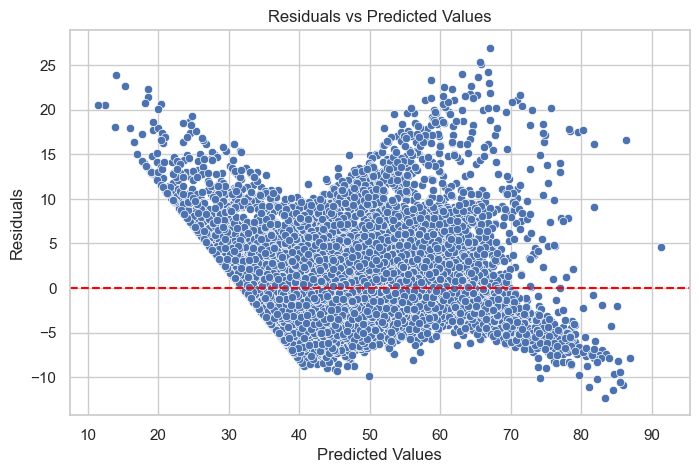

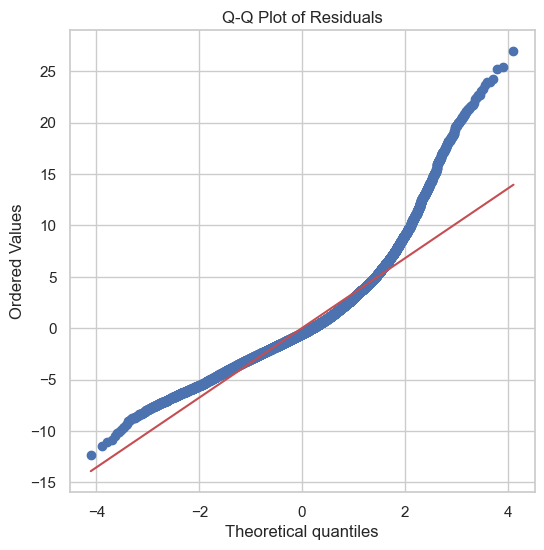

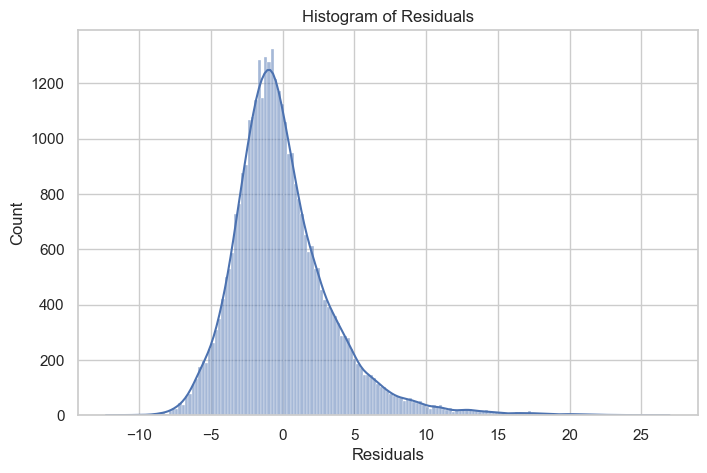

In [102]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram

# Calculate residuals
residuals = y_test - y_pred

# Plot 1: Residuals vs Predicted Values
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

# Plot 2: Q-Q Plot
plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

# Plot 3: Histogram of Residuals
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')
plt.show()

*Inference* - 
The residuals vs. predicted plot shows a clear pattern, meaning some types of deliveries are predicted less accurately — especially very fast or very slow deliveries. The Q-Q plot suggests the residuals are not perfectly normally distributed, and the histogram confirms this skew. Overall, while the model performs well, there is room for improvement, possibly through adding features or using a more flexible model.


#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [103]:
# Compare the scaled vs unscaled features used in the final model
# Step 1: Fit Linear Regression on unscaled features
lr_unscaled = LinearRegression()
lr_unscaled.fit(X_train[selected_features], y_train)

# Store unscaled coefficients
coeff_unscaled = pd.Series(lr_unscaled.coef_, index=selected_features)

# Step 2: Fit Linear Regression on scaled features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[selected_features])

lr_scaled = LinearRegression()
lr_scaled.fit(X_train_scaled, y_train)

# Store scaled coefficients
coeff_scaled = pd.Series(lr_scaled.coef_, index=selected_features)

# Step 3: Compare coefficients
coeff_comparison = pd.DataFrame({
    'Unscaled Coefficients': coeff_unscaled,
    'Scaled Coefficients': coeff_scaled
})

# Sort by absolute value of scaled coefficients (for easier interpretation)
coeff_comparison = coeff_comparison.reindex(coeff_comparison['Scaled Coefficients'].abs().sort_values(ascending=False).index)

# Display result
coeff_comparison



Unscaled Coefficients  Scaled Coefficients
total_outstanding_orders               0.350978            18.522301
total_onshift_dashers                 -0.374826           -12.958605
total_busy_dashers                    -0.140869            -4.535634
distance                               0.477443             4.178157
subtotal                               0.001662             3.043679
order_hour                            -0.262506            -2.277831
order_dayofweek                        0.206510             0.422296
total_items                            0.039535             0.107816

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

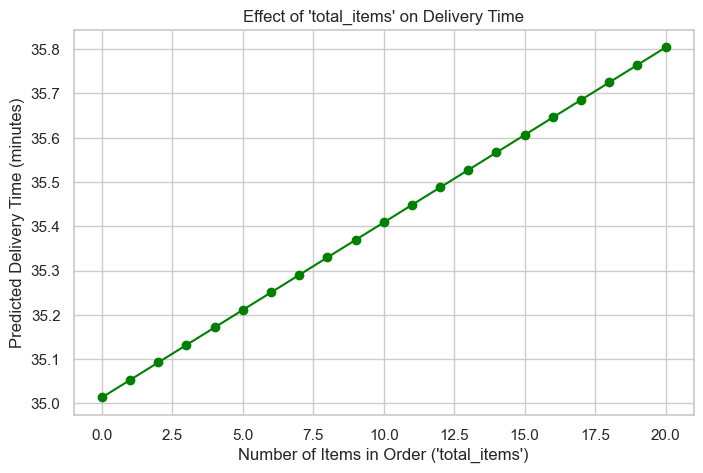

In [104]:
# Analyze the effect of a unit change in a feature, say 'total_items'

# Get coefficient of 'total_items'
coef_total_items = coeff_unscaled['total_items']
intercept = lr_model.intercept_

# Generate a range of total_items (say 0 to 20 items)
total_items_range = np.arange(0, 21, 1)

# Predicted delivery times for this range
predicted_delivery_time = intercept + coef_total_items * total_items_range

# Plot
plt.figure(figsize=(8,5))
plt.plot(total_items_range, predicted_delivery_time, marker='o', color='green')
plt.title("Effect of 'total_items' on Delivery Time")
plt.xlabel("Number of Items in Order ('total_items')")
plt.ylabel("Predicted Delivery Time (minutes)")
plt.grid(True)
plt.show()


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>Yes, the dataset has categorical variables like 'order_dayofweek' and 'isWeekend', which impact delivery time as demand and traffic vary across weekdays and weekends



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>test_size = 0.2 means 20% of the data is used for testing the model, while 80% is used for training



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>From the heatmap, the feature distance has the highest correlation with the target variable delivery_time_min — indicating that as distance increases, delivery time also tends to increase.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>IQR (Interquartile Range) method was to detect outliers in the numerical features. Data points lying beyond 1.5 times the IQR from the first (Q1) and third (Q3) quartiles were identified as outliers. Depending on the feature and analysis, we either capped these outliers or removed them to improve model performance.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
> Distance, Total items, Order Hour. These features had the highest coefficients and strongest correlation with delivery time, meaning changes in these values most strongly impact how long delivery takes.



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>Linear regression is a supervised machine learning algorithm used to model the relationship between a dependent variable (output) and one or more independent variables (inputs). It assumes a linear relationship, meaning the output changes at a constant rate with respect to the input. The relationship is represented by a straight line, often referred to as the best-fit line.

**Key Concepts**

Equation of the Line: For simple linear regression (one independent variable), the equation is: y = mx + b y: Predicted value (dependent variable) x: Input (independent variable) m: Slope (rate of change of y with respect to x) b: Intercept (value of y when x = 0) For multiple linear regression (multiple independent variables), the equation expands to: y = β₀ + β₁x₁ + β₂x₂ + ... + βₖxₖ β₀: Intercept β₁, β₂, ..., βₖ: Coefficients for each independent variable

Best-Fit Line: The goal is to minimize the error between the actual and predicted values. This is achieved using the Least Squares Method, which minimizes the Sum of Squared Errors (SSE): SSE = Σ (yᵢ - ŷᵢ)² yᵢ: Actual value ŷᵢ: Predicted value

Gradient Descent: To optimize the coefficients (m and b), gradient descent is used. It iteratively updates the parameters to minimize the Mean Squared Error (MSE): MSE = (1/n) Σ (yᵢ - ŷᵢ)² n: Number of data points

Assumptions of Linear Regression

1. Linearity: The relationship between inputs and output is linear.

2. Independence of Errors: Errors should not be correlated.

3. Homoscedasticity: Errors have constant variance across all input values.

4. Normality of Errors: Errors follow a normal distribution.

5. No Multicollinearity: Independent variables should not be highly correlated.




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>### Comparison: Simple Linear Regression vs Multiple Linear Regression

| **Aspect**                        | **Simple Linear Regression**               | **Multiple Linear Regression**                     |
|-----------------------------------|--------------------------------------------|---------------------------------------------------|
| **Number of Independent Variables**| One (X)                                    | Two or more (X₁, X₂, ..., Xₙ)                     |
| **Equation**                       | Y = b₀ + b₁X                               | Y = b₀ + b₁X₁ + b₂X₂ + ... + bₙXₙ                |
| **Model Shape**                    | Straight line                              | Plane or hyperplane                               |
| **Example**                        | Delivery time vs distance                  | Delivery time vs distance, total_items, hour      |




---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>**Role of the Cost Function in Linear Regression**

The **cost function** in linear regression measures how well the model's predictions match the actual data. Typically, **Mean Squared Error (MSE)** is used, which calculates the average of squared differences between predicted and actual values.

The goal is to minimize this cost by adjusting the model's coefficients. This minimization is performed using optimization techniques such as **Gradient Descent** or by solving the **normal equation** (closed-form solution), to find the best-fitting line for the data.





---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**
| Aspect            | Overfitting                                      | Underfitting                                   |
|-------------------|-------------------------------------------------|-----------------------------------------------|
| Model Complexity  | Too complex, captures noise in the data          | Too simple, cannot capture underlying patterns |
| Training vs Test Performance | High accuracy on training data but poor on test data | Poor accuracy on both training and test data   |
| Generalization    | Fails to generalize to new, unseen data          | Fails to perform well even on training data    |





---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
Residual plots are graphical tools that help diagnose how well a linear regression model fits the data:

1. **Linearity Check**:  
   A random scatter of residuals around zero suggests that the linearity assumption holds. Patterns or curves indicate that a linear model may not be appropriate.

2. **Homoscedasticity (Constant Variance)**:  
   If the spread of residuals remains consistent across all fitted values, the assumption of constant variance holds. A funnel shape suggests heteroscedasticity.

3. **Detecting Outliers and Influential Points**:  
   Residual plots make it easy to spot extreme residuals, which may represent outliers or influential observations affecting the model unduly.

These insights help assess the validity of the model and guide necessary improvements.
